# Homework 24

Murphy Sections 14.4 and 14.5

Math 404

Winter 2020

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools
from scipy import linalg

%matplotlib inline

## Homework Section 2: Kernel Method Coding Exercises

### Exercise 1
Write functions that compute the RBF kernel and polynomial kernel.

In [2]:
### Kernel function generators
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
def RBF_kernel(X1,X2,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    #Make a tensor M where M[i, j, :] = X1[i,:] - X2[j,:]
    M = X1[:,np.newaxis,:] - X2
    #Square and sum over last axis to get K[i,j] =  |X1[i,:] - X2[j,:]|^2
    K = (M**2).sum(axis=-1)
    #RBF kernel is exp(-|X1[i,:] - X2[j,:]|^2 / (2 * sigma**2))
    return np.exp(-K/(2*sigma**2))

def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    inner_prod = np.einsum('ik,jk->ij', X1, X2)
    return (offset + inner_prod)**degree

### Exercises 2
Use the linear kernel function dfined in the code to compute 
the kernel matrix on the set of points $x_0 \in \mathcal{D}_X = \{-4, -1, 0, 2\}$.  Include both the code and the output.

In [3]:
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)
print(linear_kernel(prototypes, prototypes))

[[16  4  0 -8]
 [ 4  1  0 -2]
 [ 0  0  0  0]
 [-8 -2  0  4]]


### Exercise 3
Suppose we have the data set $\mathcal{D} = \{(-4, 2), (-1, 0), (0, 3), (2, 5)\}$.  Then by the representer theorem, the final prediction function will be in the span of the functions $k(x_0, x)$ for $x_0 \in \mathcal{D}_X$.
This set of functions will look quite different depending on the kernel function we use.

#### Parts (a) through (c):

Plot kernel functions.

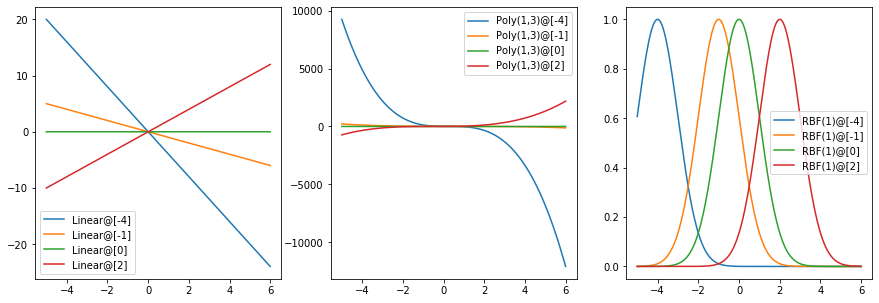

In [4]:
# PLot kernel machine functions

plot_step = .01
xpts = np.arange(-5.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.ravel()
poly13 = lambda x1, x2 : polynomial_kernel(x1, x2, 1, 3)
RBF1 = lambda x1, x2 : RBF_kernel(x1, x2, 1)
kernels = [linear_kernel, poly13, RBF1]
kernel_names = ['Linear', 'Poly(1,3)', 'RBF(1)']
for ax, kernel, kernel_name in zip(axes, kernels, kernel_names):
    y = kernel(prototypes, xpts) 
    for i in range(len(prototypes)):
        label = "{0}@{1}".format(kernel_name,prototypes[i,:])
        ax.plot(xpts, y[i,:], label=label)
    ax.legend(loc = 'best')

plt.show() 
 
 

#### Part (d)
Complete the ``predict()`` function of the class ``Kernel_Machine``.

In [5]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R with entries w_1,...,w_R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
        return np.einsum('i...,ji->j...', self.weights, self.kernel(X, self.prototype_points))

Construct a ``Kernel_Machine`` object with the RBF kernel (sigma=1), with prototype points at -1,0,1 and corresponding weights 1,-1,1.  Plot the resulting function.

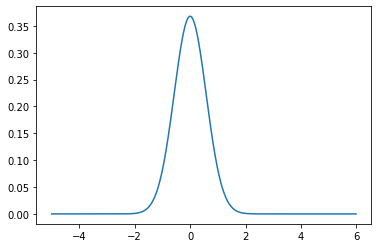

In [6]:
RBF1KM = Kernel_Machine(RBF1, np.array([-1, 0, 1]).reshape((1, -1)), np.array([1, -1, 1]))
plt.plot(xpts, RBF1KM.predict(xpts))
plt.show()

## Homework Section 2.1: Kernel Ridge Regression

Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [7]:
data_train = np.loadtxt(os.path.join("rosenberg_data" ,"krr-train.txt"))
data_test = np.loadtxt(os.path.join("rosenberg_data" ,"krr-test.txt"))
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

### 1. Plot the training data.

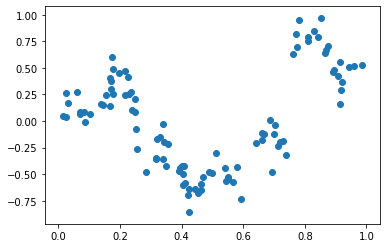

In [8]:
plt.scatter(x_train, y_train)
plt.show()

### 2.
Complete the function ``train_kernel_ridge_regression`` so that it performs kernel ridge regression and regurns a ``Kernel_Machine`` object that can be use for predicting on new points.

In [9]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    K = kernel(X, X)
    alpha = linalg.solve(np.eye(y.shape[0])*l2reg + K, y, assume_a='sym')
    return Kernel_Machine(kernel, X, alpha)

### 3.
Use this code to polot your fits to the training data for the RBF kernel with a fixed regularization parameter of 0.0001 for 3 differet values of sigma: 0,01, 0.1, 1.0.  What values of sigma do you think would be more likely to overfit, and which less?

*I think smaller values of sigma are more likely to overfit.*

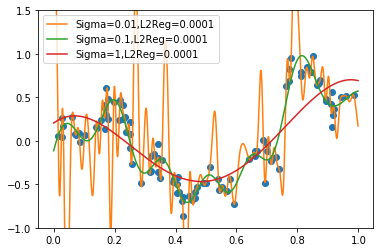

In [10]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

### 4.
Plot fits with fixed sigma and different regularization parameter.

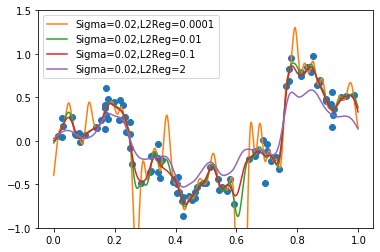

In [11]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

#### What happens to the prediction as $\lambda \to \infty$?
It becomes 0 everywhere.

In [12]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [13]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [14]:
param_grid = [{'kernel': ['RBF'],'sigma':[.1,1,10], 'l2reg': np.exp2(-np.arange(-5,5,1))},
              {'kernel':['polynomial'],'offset':[-1,0,1], 'degree':[2,3,4],'l2reg':[10, .1, .01] },
              {'kernel':['linear'],'l2reg': [10,1,.01]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False),
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                    return_train_score=True
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=nan,
             estimator=KernelRidgeRegression(degree=2, kernel='RBF', l2reg=1,
                                             offset=1, sigma=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'kernel': ['RBF'],
                          'l2reg': array([32.    , 16.    ,  8.    ,  4.    ,  2.    ,  1.    ,  0.5   ,
        0.25  ,  0.125 ,  0.0625]),
                          'sigma': [0.1, 1, 10]},
                         {'degree': [2, 3, 4], 'kernel': ['polynomial'],
                          'l2reg': [10, 0.1, 0.01], 'offset': [-1, 0, 1]},
                         {'kernel': ['linear'], 'l2reg': [10, 1, 0.01]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=0)

In [15]:
pd.set_option('display.max_rows', 1000)
df = pd.DataFrame(grid.cv_results_)
#df

In [16]:
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

param_degree param_kernel  param_l2reg param_offset param_sigma  \
27            -          RBF       0.0625            -         0.1   
24            -          RBF       0.1250            -         0.1   
21            -          RBF       0.2500            -         0.1   
18            -          RBF       0.5000            -         0.1   
15            -          RBF       1.0000            -         0.1   
12            -          RBF       2.0000            -         0.1   
9             -          RBF       4.0000            -         0.1   
6             -          RBF       8.0000            -         0.1   
54            4   polynomial       0.0100           -1           -   
3             -          RBF      16.0000            -         0.1   
56            4   polynomial       0.0100            1           -   
28            -          RBF       0.0625            -           1   
33            2   polynomial       0.1000           -1           -   
38            2   polynomial       0.0100            1           -   
36            2   polynomial       0.0100           -1           -   
35            2   polynomial       0.1000            1           -   
44            3   polynomial       0.1000            1           -   
45            3   polynomial       0.0100           -1           -   
53            4   polynomial       0.1000            1           -   
42            3   polynomial       0.1000           -1           -   
47            3   polynomial       0.0100            1           -   
25            -          RBF       0.1250            -           1   
0             -          RBF      32.0000            -         0.1   
22            -          RBF       0.2500            -           1   
19            -          RBF       0.5000            -           1   
50            4   polynomial      10.0000            1           -   
16            -          RBF       1.0000            -           1   
41            3   polynomial      10.0000            1           -   
52            4   polynomial       0.1000            0           -   
55            4   polynomial       0.0100            0           -   
13            -          RBF       2.0000            -           1   
49            4   polynomial      10.0000            0           -   
43            3   polynomial       0.1000            0           -   
46            3   polynomial       0.0100            0           -   
48            4   polynomial      10.0000           -1           -   
40            3   polynomial      10.0000            0           -   
32            2   polynomial      10.0000            1           -   
10            -          RBF       4.0000            -           1   
34            2   polynomial       0.1000            0           -   
37            2   polynomial       0.0100            0           -   
31            2   polynomial      10.0000            0           -   
7             -          RBF       8.0000            -           1   
29            -          RBF       0.0625            -          10   
4             -          RBF      16.0000            -           1   
26            -          RBF       0.1250            -          10   
1             -          RBF      32.0000            -           1   
23            -          RBF       0.2500            -          10   
58            -       linear       1.0000            -           -   
59            -       linear       0.0100            -           -   
57            -       linear      10.0000            -           -   
20            -          RBF       0.5000            -          10   
17            -          RBF       1.0000            -          10   
14            -          RBF       2.0000            -          10   
11            -          RBF       4.0000            -          10   
8             -          RBF       8.0000            -          10   
5             -          RBF      16.0000            -          10   
2            

In [17]:
# Can be a more convenient way to look at the table
import qgrid 
#qgrid.nbinstall(overwrite=True)  # copies javascript dependencies to your /nbextensions folderd_toshow = df[show].fillna('-')
qgrid.show_grid(df_toshow)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

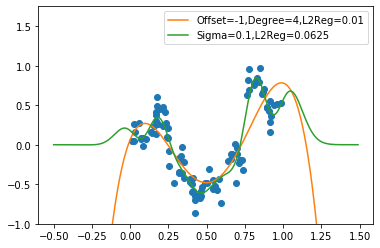

In [18]:
## Plot the best polynomial and RBF fits you found
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
bestind = df.loc[df.param_kernel=='polynomial' ,'mean_test_score'].idxmin()
offset, degree, l2reg = df.loc[bestind, ['param_offset', 'param_degree', 'param_l2reg']]
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
bestind = df.loc[df.param_kernel=='RBF', 'mean_test_score'].idxmin()
l2reg, sigma = df.loc[bestind, ['param_l2reg', 'param_sigma']]
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

In [26]:
#Time to waste a bunch of time on tuning hyperparameters.
gridRBF = None
previous_RBF_mean_test_score = np.inf
small_change = .001
current_RBF_mean_test_score = None

sigma_log_upper = 20
sigma_log_lower = -20

l2reg_log_upper = 40
l2reg_log_lower = -20

#If you want this to fit closer, then increase iterations.
for i in range(100):
    print("Iteration {0}.".format(i), end='\r')
    #print(""\t sigma_log_upper is {1}.  sigma_log_lower is {2}".format(i, sigma_log_upper, sigma_log_lower))
    #print("\tl2reg_log_upper is {0}. l2reg_lower is {1}.".format(l2reg_log_upper, l2reg_log_lower))
    #Make new grid.
    sigma_log_grid = np.linspace(sigma_log_lower, sigma_log_upper, 15)
    sigma_grid = 10**sigma_log_grid
    
    l2reg_log_grid = np.linspace(l2reg_log_lower, l2reg_log_upper, 15)
    l2reg_grid = 2**(l2reg_log_grid)
    
    #Perform grid search.
    param_grid = [{'kernel': ['RBF'],'sigma':sigma_grid, 'l2reg': l2reg_grid}]
    gridRBF = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False))
    gridRBF.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test)))
    
    #Find optimal point & see how well we improved.
    df = pd.DataFrame(gridRBF.cv_results_)
    df['mean_test_score'] = -df['mean_test_score']
    bestind = df.loc[:, 'mean_test_score'].idxmin()
    current_RBF_mean_test_score = df.mean_test_score.min()
    #print("\tmean_test_score is", current_RBF_mean_test_score)
    l2reg_center, sigma_center = df.loc[bestind, ['param_l2reg', 'param_sigma']]
    
    #Find the index of this center point.
    i_sigma = np.searchsorted(sigma_grid, sigma_center, side='right')
    i_l2reg = np.searchsorted(l2reg_grid, l2reg_center, side='right')
    
    change = abs(previous_RBF_mean_test_score - current_RBF_mean_test_score)
    if change < small_change:
        if abs(sigma_grid[i_sigma] - sigma_grid[i_sigma+1]) < .01:
            if abs(l2reg_grid[i_l2reg] - l2reg_grid[i_l2reg+1]) < .01:
                break
        
    else:
        #Move the grid in around the maximal point.
        sigma_log_upper = sigma_log_grid[min(i_sigma+3, sigma_log_grid.size-1)]
        sigma_log_lower = sigma_log_grid[max(i_sigma-3, 0)]

        l2reg_log_upper = l2reg_log_grid[min(i_l2reg+3, l2reg_log_grid.size-1)]
        l2reg_log_lower = l2reg_log_grid[max(i_l2reg-3, 0)]
        
        previous_RBF_mean_test_score = current_RBF_mean_test_score

RBFcols_to_keep = ["param_kernel","param_l2reg" ,"param_sigma", "mean_test_score"]
df.loc[:,RBFcols_to_keep].fillna('-').sort_values(by=["mean_test_score"]).head(15)

param_kernel  param_l2reg  param_sigma  mean_test_score
50           RBF     0.315587     0.054183         0.013835
35           RBF     0.259711     0.054183         0.013838
20           RBF     0.213727     0.054183         0.013913
65           RBF     0.383485     0.054183         0.013917
5            RBF     0.175886     0.054183         0.014046
80           RBF     0.465992     0.054183         0.014102
95           RBF     0.566249     0.054183         0.014403
94           RBF     0.566249     0.032282         0.014564
79           RBF     0.465992     0.032282         0.014585
109          RBF     0.688077     0.032282         0.014701
64           RBF     0.383485     0.032282         0.014727
110          RBF     0.688077     0.054183         0.014836
49           RBF     0.315587     0.032282         0.014958
124          RBF     0.836116     0.032282         0.015043
34           RBF     0.259711     0.032282         0.015254

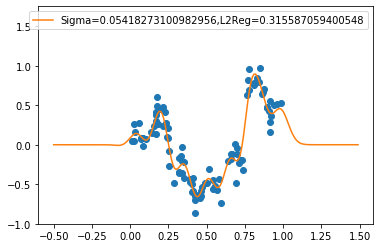

In [27]:
#Plot best RBF fit
plt.plot(x_train,y_train,'o')
bestind = df.loc[df.param_kernel=='RBF', 'mean_test_score'].idxmin()
l2reg, sigma = df.loc[bestind, ['param_l2reg', 'param_sigma']]
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

In [28]:
#That took me like an hour to write and then debug.  I don't have time for doing this with a polynomial kernel.

### 6.
Comment on results:  Look!  Spending forever tuning those hyperparameters moderately increased how the function fits the data.

### 7.
I have no idea what a Bayes decision function or Bayes risk is.